# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version  = '03'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data='ice'

fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 2483775)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 00:45:20 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    qi   = xr.open_dataset(fname).q_ice.values
    ni   = xr.open_dataset(fname).n_ice.values
    temp = xr.open_dataset(fname).temp.values
    # mean cross sectional area, number weighted, multiply with ni for total area
    ai  = xr.open_dataset(fname).ice_area.values
    # some numerical lower bounds
    q_min = 1e-12
    n_min = 1e-12
    z_min = 1e-20
    p_min = 1e-20
    # ice density
    rhoi = 916.7
    # reff following Fu (1996) and Foot (1988), here Eq. (3.11) of Fu (1996)
    reff = np.where(ni>q_min,3./4.*qi/(ai*ni*rhoi),np.nan)   
    # transform everything in log space
    ni = np.log(ni, where=ni>n_min, out=np.nan*ni)
    qi = np.log(qi, where=qi>q_min, out=np.nan*qi)
    reff = np.log(reff, where=reff>p_min, out=np.nan*reff)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ qi, ni, temp, reff ]))
    dataset = dataset.T
    dataset.columns = [ 'qi', 'ni', 'temp','reff' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

### Split in training, testing and validation with 70/15/15 rule

In [8]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [9]:
dataset_train.head()

qi         ni        temp       reff
1 -9.098263  11.622676  243.710007 -10.775322
3 -9.107783  11.613495  243.850006 -10.776936
4 -9.112307  11.609235  243.929993 -10.777708
6 -9.117306  11.601485  244.070007 -10.778261
7 -9.120774  11.597083  244.139999 -10.778594

In [10]:
dataset_train.describe()

qi            ni          temp          reff
count  1.739080e+06  1.739080e+06  1.739080e+06  1.739080e+06
mean  -9.531016e+00  1.352521e+01  2.407675e+02 -1.124568e+01
std    3.251820e+00  3.878884e+00  1.311038e+01  2.873897e-01
min   -2.302555e+01 -4.851992e+00  2.067200e+02 -1.255000e+01
25%   -9.770746e+00  1.200267e+01  2.312300e+02 -1.145358e+01
50%   -8.680006e+00  1.418969e+01  2.405200e+02 -1.124707e+01
75%   -7.703334e+00  1.624031e+01  2.490500e+02 -1.103086e+01
max   -4.315790e+00  2.052169e+01  2.738200e+02 -8.750051e+00

In [11]:
dataset_test.describe()

qi             ni           temp           reff
count  371524.000000  371524.000000  371524.000000  371524.000000
mean       -9.538111      13.517443     240.763107     -11.245626
std         3.257607       3.884129      13.132728       0.287134
min       -23.025551      -3.753141     206.789993     -12.354890
25%        -9.781469      11.992694     231.190002     -11.453421
50%        -8.679300      14.182581     240.520004     -11.246801
75%        -7.704809      16.234989     249.100006     -11.031596
max        -4.363165      20.515467     273.769989      -8.914130

In [12]:
dataset_val.describe()

qi             ni           temp           reff
count  373171.000000  373171.000000  373171.000000  373171.000000
mean       -9.534830      13.523419     240.797775     -11.246230
std         3.257152       3.883559      13.112783       0.287440
min       -23.025452      -4.852273     206.649994     -12.453779
25%        -9.786327      11.994116     231.250000     -11.453712
50%        -8.680006      14.190379     240.539993     -11.247697
75%        -7.698967      16.242523     249.100006     -11.031733
max        -4.347277      20.519730     273.779999      -8.977053

### Further reduce data to relevant parameter range

In [13]:
def reduce_data(dataset):
    idx = dataset[ dataset['reff'] > -9 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['qi'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['ni'] < -10 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['temp'] > 270 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [14]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [15]:
dataset_train.describe()

qi            ni          temp          reff
count  1.666618e+06  1.666618e+06  1.666618e+06  1.666618e+06
mean  -9.124813e+00  1.396419e+01  2.396044e+02 -1.125386e+01
std    2.562970e+00  3.256912e+00  1.204753e+01  2.737894e-01
min   -1.999998e+01 -1.163119e+00  2.067200e+02 -1.233208e+01
25%   -9.525970e+00  1.230651e+01  2.307600e+02 -1.145646e+01
50%   -8.609089e+00  1.434237e+01  2.398600e+02 -1.125427e+01
75%   -7.651964e+00  1.631744e+01  2.478300e+02 -1.104560e+01
max   -4.315790e+00  2.052169e+01  2.700000e+02 -9.794505e+00

In [16]:
dataset_test.describe()

qi             ni           temp           reff
count  356002.000000  356002.000000  356002.000000  356002.000000
mean       -9.130578      13.957786     239.595734     -11.253786
std         2.567953       3.260873      12.068728       0.273671
min       -19.999929      -1.163151     206.789993     -12.332075
25%        -9.533784      12.303120     230.720001     -11.456322
50%        -8.608979      14.336386     239.869995     -11.254192
75%        -7.653802      16.312901     247.860001     -11.045580
max        -4.363165      20.515467     270.000000     -10.340535

### Pairplot

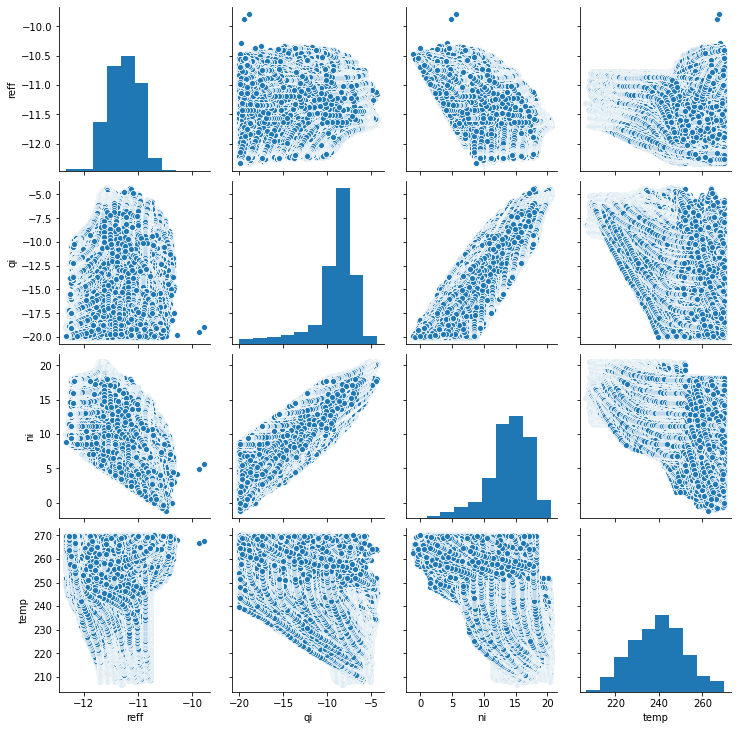

In [17]:
sns.pairplot(dataset_train[["reff","qi","ni","temp"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [18]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()

In [19]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()

In [20]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()

In [21]:
#train_dataset1 = train_dataset1.drop(['temp','rho','ssi'], axis=1)
#train_dataset2 = train_dataset2.drop(['temp','ssi'], axis=1)
#train_dataset3 = train_dataset3.drop(['ssi'], axis=1)

In [22]:
#test_dataset1 = test_dataset1.drop(['temp','rho','ssi'], axis=1)
#test_dataset2 = test_dataset2.drop(['temp','ssi'], axis=1)
#test_dataset3 = test_dataset3.drop(['ssi'], axis=1)

In [23]:
#val_dataset1 = val_dataset1.drop(['temp','rho','ssi'], axis=1)
#val_dataset2 = val_dataset2.drop(['temp','ssi'], axis=1)
#val_dataset3 = val_dataset3.drop(['ssi'], axis=1)

In [24]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("reff")
train_stats1 = train_stats1.transpose()
train_stats1

count        mean        std         min         25%         50%  \
qi    1666618.0   -9.124813   2.562970  -19.999977   -9.525970   -8.609089   
ni    1666618.0   13.964194   3.256912   -1.163119   12.306506   14.342367   
temp  1666618.0  239.604416  12.047526  206.720001  230.759995  239.860001   

             75%         max  
qi     -7.651964   -4.315790  
ni     16.317438   20.521688  
temp  247.830002  270.000000

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [25]:
# pop does not work for multiple columns, use copy instead

labels = ['reff']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [26]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [27]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [28]:
train_labels.describe()

reff
count  1.666618e+06
mean  -1.125386e+01
std    2.737894e-01
min   -1.233208e+01
25%   -1.145646e+01
50%   -1.125427e+01
75%   -1.104560e+01
max   -9.794505e+00

In [29]:
train_dataset1.describe()

qi            ni          temp
count  1.666618e+06  1.666618e+06  1.666618e+06
mean  -9.124813e+00  1.396419e+01  2.396044e+02
std    2.562970e+00  3.256912e+00  1.204753e+01
min   -1.999998e+01 -1.163119e+00  2.067200e+02
25%   -9.525970e+00  1.230651e+01  2.307600e+02
50%   -8.609089e+00  1.434237e+01  2.398600e+02
75%   -7.651964e+00  1.631744e+01  2.478300e+02
max   -4.315790e+00  2.052169e+01  2.700000e+02

### Normalize the features

In [30]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_test_data1 = norm(test_dataset1,train_stats1)
normed_val_data1 = norm(val_dataset1,train_stats1)

In [31]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
qi    1666618.0  9.561319e-07  1.0 -4.243188 -0.156520  0.201221  0.574665   
ni    1666618.0  1.434185e-06  1.0 -4.644680 -0.508975  0.116114  0.722538   
temp  1666618.0 -4.087196e-07  1.0 -2.729557 -0.734128  0.021215  0.682761   

           max  
qi    1.876348  
ni    2.013408  
temp  2.522973

### Normalize the labels

In [32]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count      mean       std        min        25%       50%  \
reff  1666618.0 -11.25386  0.273789 -12.332075 -11.456457 -11.25427   

            75%       max  
reff -11.045601 -9.794505

In [33]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [34]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H2(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H1(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(1)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H1":
        model = build_model_relu_Adam_H1(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H2":
        model = build_model_relu_Adam_H2(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [35]:

activ = "ReLU_Adam_H1"

model = build_model(3,6,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [36]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6)                 24        
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 42        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 7         
Total params: 73
Trainable params: 73
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [37]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[0.14883444],
       [0.15782958],
       [0.16288903],
       [0.17136505],
       [0.17570552],
       [0.18042079],
       [0.18485321],
       [0.1890055 ],
       [0.19375293],
       [0.19772506]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [38]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=5)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [39]:
nsize = 8
activ = "ReLU_Adam_H1"
model1 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0168,  mae:0.0649,  mse:0.0168,  val_loss:0.0104,  val_mae:0.0565,  val_mse:0.0104,  
.........................

Text(0, 0.5, 'MAE')

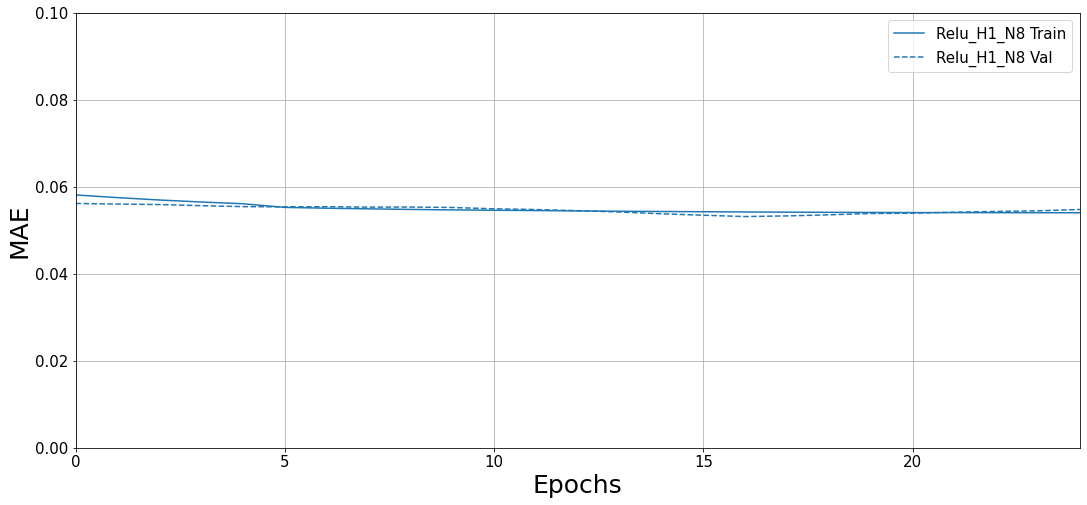

In [40]:
histories['ReLU_H1_n8'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.0,0.10])
plt.ylabel('MAE')

In [41]:
nsize = 16
model2 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0128,  mae:0.0578,  mse:0.0128,  val_loss:0.0098,  val_mae:0.0536,  val_mse:0.0098,  
.......................

Text(0, 0.5, 'MAE')

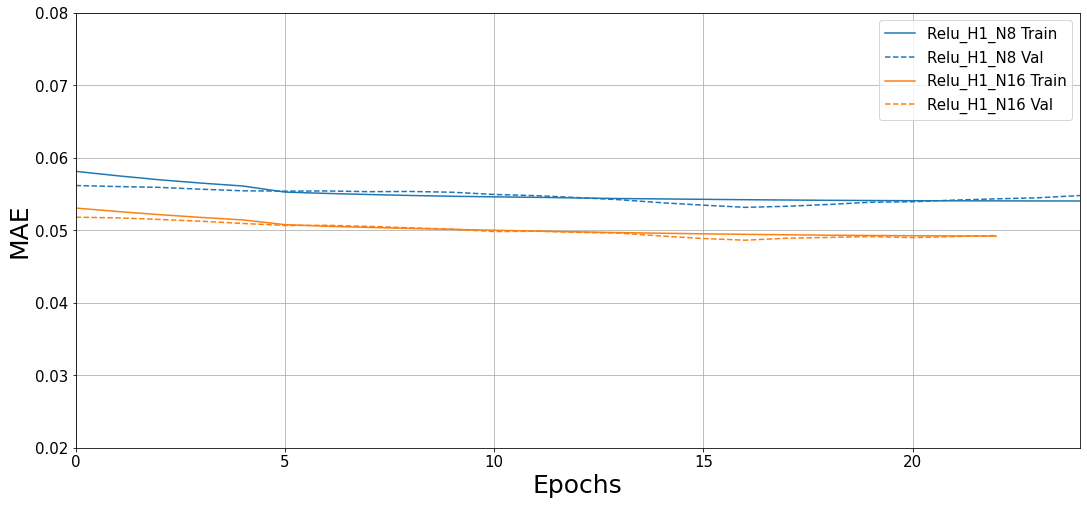

In [42]:
histories['ReLU_H1_n16'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.02, 0.08])
plt.ylabel('MAE')

In [43]:
nsize = 8
activ = "ReLU_Adam_H2"
model3 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0173,  mae:0.0662,  mse:0.0173,  val_loss:0.0108,  val_mae:0.0586,  val_mse:0.0108,  
....................

Text(0, 0.5, 'MAE')

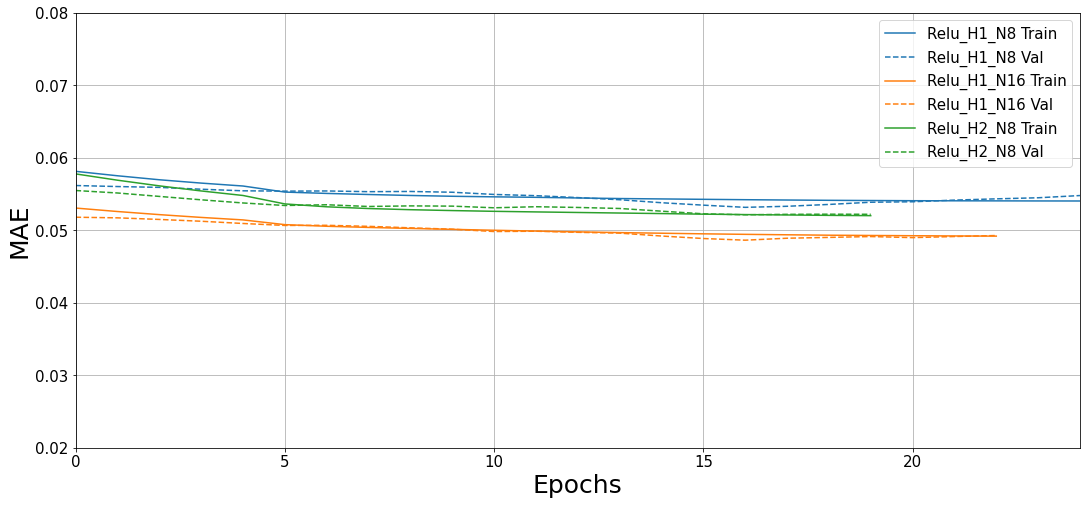

In [44]:
histories['ReLU_H2_n8'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.02, 0.08])
plt.ylabel('MAE')

In [45]:
nsize = 16
activ = "ReLU_Adam_H2"
model4 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history4 = model4.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0125,  mae:0.0588,  mse:0.0125,  val_loss:0.0092,  val_mae:0.0514,  val_mse:0.0092,  
....................

Text(0, 0.5, 'MAE')

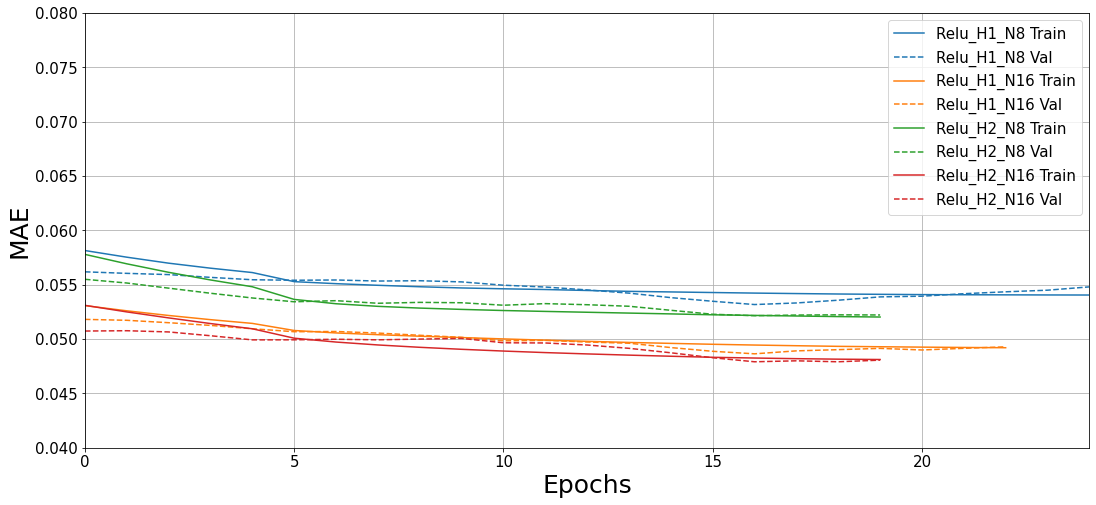

In [47]:
histories['ReLU_H2_n16'] = early_history4

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mae")
plt.ylim([0.04, 0.08])
plt.ylabel('MAE')

Text(0, 0.5, 'MSE')

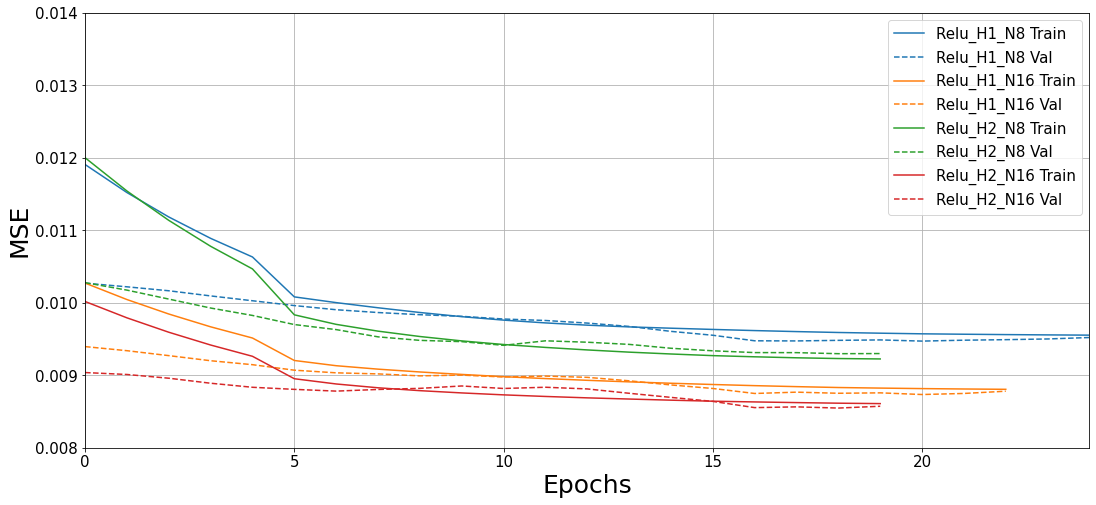

In [49]:
plotter.plot(histories, metric = "mse")
plt.ylim([0.008, 0.014])
plt.ylabel('MSE')

In [50]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

356002/356002 - 8s - loss: 0.0093 - mae: 0.0521 - mse: 0.0093
Testing set for model 1, Mean Abs Error:    0.05208


In [51]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

356002/356002 - 8s - loss: 0.0087 - mae: 0.0491 - mse: 0.0087
Testing set for model 2, Mean Abs Error:              0.04905


In [52]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

356002/356002 - 8s - loss: 0.0091 - mae: 0.0512 - mse: 0.0091
Testing set for model 3, Mean Abs Error:              0.05118


In [53]:
loss4, mae4, mse4 = model4.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 4, Mean Abs Error: {:20.5f}".format(mae4))

356002/356002 - 8s - loss: 0.0084 - mae: 0.0460 - mse: 0.0084
Testing set for model 4, Mean Abs Error:              0.04596


In [54]:
mae = [ mae1, mae2, mae3, mae4 ]
mae

[0.052076884, 0.04905133, 0.051176187, 0.045963682]

In [55]:
mse = [ mse1, mse2, mse3, mse4 ]
mse

[0.00934237, 0.008671329, 0.009100024, 0.008383611]

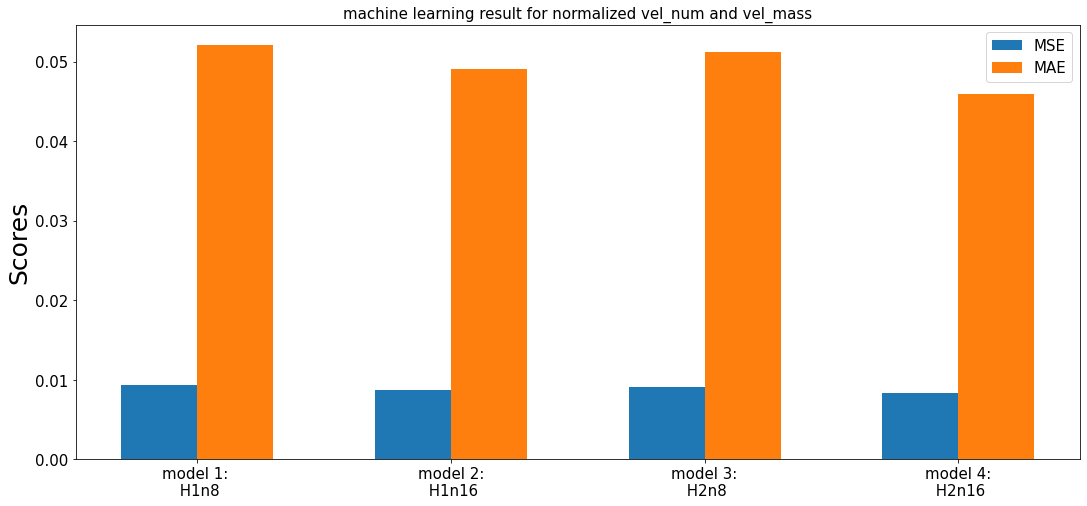

In [56]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['model 1: \n H1n8',
 'model 2:\n H1n16',
 'model 3:\n H2n8',
 'model 4:\n H2n16' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized vel_num and vel_mass')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [57]:
test_true_reff  = np.exp(test_labels.pop('reff'))

In [58]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [59]:
p1 = pd.DataFrame(data=model1.predict(normed_test_data1), columns=["reff"])

In [60]:
p1.describe()

reff
count  356002.000000
mean       -0.000843
std         1.000052
min        -3.916219
25%        -0.755577
50%         0.005433
75%         0.759133
max         3.176521

In [61]:
train_labels_stats

count      mean       std        min        25%       50%  \
reff  1666618.0 -11.25386  0.273789 -12.332075 -11.456457 -11.25427   

            75%       max  
reff -11.045601 -9.794505

In [62]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [63]:
test_predict1.describe()

reff
count  356002.000000
mean        0.000013
std         0.000004
min         0.000004
25%         0.000011
50%         0.000013
75%         0.000016
max         0.000031

In [64]:
test_predict1_reff  = test_predict1['reff']

In [65]:

p2 = pd.DataFrame(data=model1.predict(normed_test_data1), columns=["reff"])

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_reff  = test_predict2['reff']

In [66]:

p3 = pd.DataFrame(data=model2.predict(normed_test_data1), columns=["reff"])

test_predict3 = np.exp(backtransform(p3,train_labels_stats))

test_predict3_reff = test_predict3['reff']

In [67]:

p4 = pd.DataFrame(data=model3.predict(normed_test_data1), columns=["reff"])

test_predict4 = np.exp(backtransform(p4,train_labels_stats))

test_predict4_reff  = test_predict4['reff']

### Maybe the ordering of the arrays is different? 

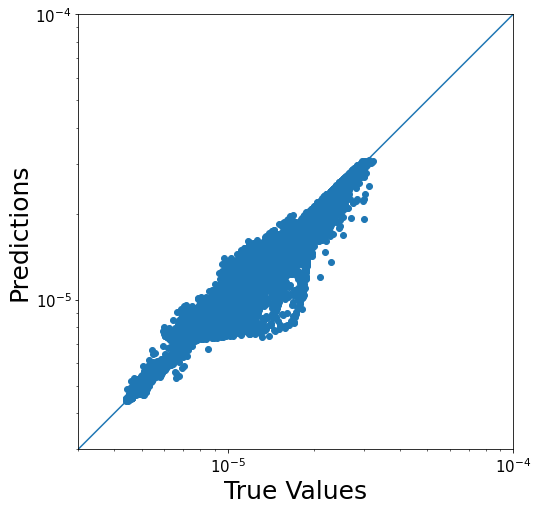

In [69]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 3e-6, 1e-4

a = plt.axes(aspect='equal')
plt.scatter(test_true_reff, test_predict1_reff)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

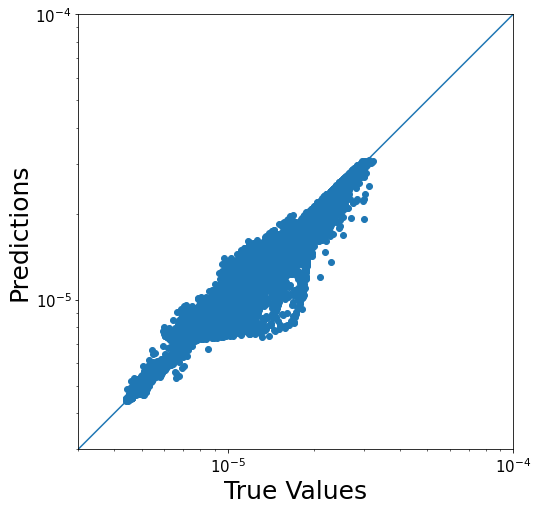

In [70]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_reff, test_predict2_reff)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

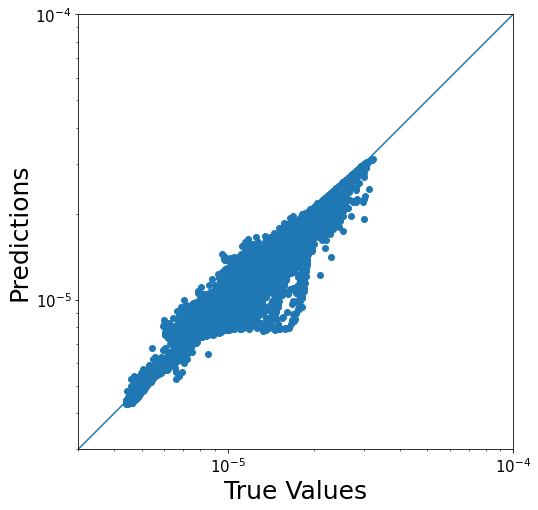

In [71]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_reff, test_predict3_reff)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

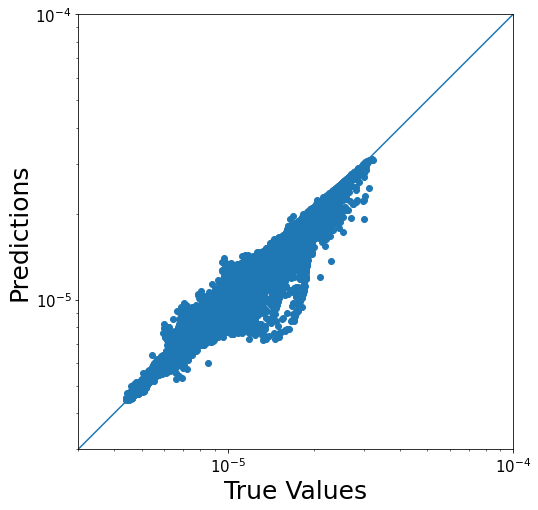

In [72]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_reff, test_predict4_reff)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [73]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [74]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

        
    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [75]:
features = 'qi, ni, temp'
labels   = 'reff'
logtransform = np.array([True, True, False], dtype=bool)

save2netcdf(model1,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/reff_ice_model1_'+version+'.nc')
save2netcdf(model2,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/reff_ice_model2_'+version+'.nc')
save2netcdf(model3,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/reff_ice_model3_'+version+'.nc')
save2netcdf(model4,features,labels,train_stats1,train_labels_stats,logtransform,'saved_model_v2/reff_ice_model4_'+version+'.nc')


Saving model to saved_model_v2/reff_ice_model1_03.nc
  Features:   qi, ni, temp
  Labels:     reff
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (3, 8), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 8), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 1), Activation: linear
Saving model to saved_model_v2/reff_ice_model2_03.nc
  Features:   qi, ni, temp
  Labels:     reff
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (3, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 1), Activation: linear
Saving model to saved_model_v2/reff_ice_model3_03.nc
  Features:   qi, ni, temp
  Labels:     reff
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (3, 8), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (8, 8), 

In [76]:
train_stats1

count        mean        std         min         25%         50%  \
qi    1666618.0   -9.124813   2.562970  -19.999977   -9.525970   -8.609089   
ni    1666618.0   13.964194   3.256912   -1.163119   12.306506   14.342367   
temp  1666618.0  239.604416  12.047526  206.720001  230.759995  239.860001   

             75%         max  
qi     -7.651964   -4.315790  
ni     16.317438   20.521688  
temp  247.830002  270.000000